## Datos

Se eligieron para completar el trabajo datos correspondientes a reviews bajo la categoría de instrumentos musicales.

## Import libraries

In [1]:
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import re
from nltk.corpus import stopwords

from collections import Counter
from nltk import ngrams
from nltk.probability import FreqDist

from gensim.models.word2vec import LineSentence
from gensim.models import Word2Vec

from sklearn.manifold import TSNE

from wordcloud import WordCloud
%matplotlib inline

# Cargar el dataset

In [2]:
path_data = '../data/Musical_Instruments_5.json'

In [3]:
### Se cargan los datos en una lista

data = []
with open(path_data) as f:
    for l in f:
        data.append(json.loads(l.strip()))
    
# Se imprime el número de reviews en la lista
print(len(data))

# Se muestra la primera columna de la lista
print(data[0])

10261
{'reviewerID': 'A2IBPI20UZIR0U', 'asin': '1384719342', 'reviewerName': 'cassandra tu "Yeah, well, that\'s just like, u...', 'helpful': [0, 0], 'reviewText': "Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,", 'overall': 5.0, 'summary': 'good', 'unixReviewTime': 1393545600, 'reviewTime': '02 28, 2014'}


In [4]:
# Se convierte la lista a un dataframe de pandas

raw_data = pd.DataFrame.from_dict(data)
print(len(raw_data))

10261


In [5]:
# número de columnas
raw_data.columns

Index(['reviewerID', 'asin', 'reviewerName', 'helpful', 'reviewText',
       'overall', 'summary', 'unixReviewTime', 'reviewTime'],
      dtype='object')

In [6]:
# Ver las primeras 5 filas
raw_data.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter is great. It looks and perform...      5.0   

                                 summary  unixReviewTime   reviewTime  
0                                   good      1393545600  02 28, 2014  
1                                   Jake      1363392000  03 16, 2013  
2                   It Does The Job Well      1377648000  08 28, 2013  
3          GOOD WINDSCREEN FOR THE MONEY      1392336000  02 14, 2014  
4  No more pops when I record my vocals.      1392940800  02 21, 2014

In [7]:
# Ver las últimas 5 filas
raw_data.tail()

reviewerID        asin             reviewerName helpful  \
10256  A14B2YH83ZXMPP  B00JBIVXGC          Lonnie M. Adams  [0, 0]   
10257   A1RPTVW5VEOSI  B00JBIVXGC       Michael J. Edelman  [0, 0]   
10258   AWCJ12KBO5VII  B00JBIVXGC         Michael L. Knapp  [0, 0]   
10259  A2Z7S8B5U4PAKJ  B00JBIVXGC  Rick Langdon "Scriptor"  [0, 0]   
10260  A2WA8TDCTGUADI  B00JBIVXGC          TheTerrorBeyond  [0, 0]   

                                              reviewText  overall  \
10256            Great, just as expected.  Thank to all.      5.0   
10257  I've been thinking about trying the Nanoweb st...      5.0   
10258  I have tried coated strings in the past ( incl...      4.0   
10259  Well, MADE by Elixir and DEVELOPED with Taylor...      4.0   
10260  These strings are really quite good, but I wou...      4.0   

                                                 summary  unixReviewTime  \
10256                                         Five Stars      1405814400   
10257  Long life, and for some players, a good econom...      1404259200   
10258                                   Good for coated.      1405987200   
10259                                        Taylor Made      1404172800   
10260  These strings are really quite good, but I wou...      1405468800   

        reviewTime  
10256  07 20, 2014  
10257   07 2, 2014  
10258  07 22, 2014  
10259   07 1, 2014  
10260  07 16, 2014

In [8]:
# Me quedo solo con las columnas de el texto de las reviews y el número de estrellas

data_reviews = raw_data[['reviewText', 'overall']]
data_reviews.head(3)

reviewText  overall
0  Not much to write about here, but it does exac...      5.0
1  The product does exactly as it should and is q...      5.0
2  The primary job of this device is to block the...      5.0

In [9]:
# Se chequea por valores faltantes

data_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  10261 non-null  object 
 1   overall     10261 non-null  float64
dtypes: float64(1), object(1)
memory usage: 160.5+ KB


no hay valores faltantes

In [10]:
# Se chequea por entradas duplicadas

dup = data_reviews[data_reviews.duplicated(subset=['reviewText', 'overall'],keep=False)]
dup.shape

(6, 2)

In [11]:
dup

reviewText  overall
2927                 5.0
8739                 5.0
9175                 5.0
9306                 5.0
9313                 5.0
9342                 5.0

no hay información en esas 6 filas así que solo las quitaré

In [12]:
data_review_nodup = data_reviews.drop_duplicates(subset=['reviewText', 'overall'],keep=False,inplace=False)
data_review_nodup.shape

(10255, 2)

# Cardinalidad del Vocabulario

In [13]:
# lista de contracciones de http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python

contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [14]:
def clean_text(text, remove_stopwords = False):
    '''Función que remueve caracteres indeseados, stopwords y da formato al texto'''
    
    # Se para el texto a minúsculas
    text = text.lower()
    
    # Se reemplazan las contracciones
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Se da formato y se remueven los caracteres indeseados
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # se remueven las stopwords
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [15]:
# Se limpian las reviews

clean_texts = []
for text in data_review_nodup.reviewText:
    clean_texts.append(clean_text(text))
print("Texts are complete.")

Texts are complete.


In [16]:
# Se muestran las primeras 5 reviews
for i in range(5):
    print("Clean Review #",i+1)
    print(clean_texts[i])
    print()

Clean Review # 1
not much to write about here  but it does exactly what it is supposed to  filters out the pop sounds  now my recordings are much more crisp  it is one of the lowest prices pop filters on amazon so might as well buy it  they honestly work the same despite their pricing 

Clean Review # 2
the product does exactly as it should and is quite affordable i did not realized it was double screened until it arrived  so it was even better than i had expected as an added bonus  one of the screens carries a small hint of the smell of an old grape candy i used to buy  so for reminiscent s sake  i cannot stop putting the pop filter next to my nose and smelling it after recording   dif you needed a pop filter  this will work just as well as the expensive ones  and it may even come with a pleasing aroma like mine did buy this product    

Clean Review # 3
the primary job of this device is to block the breath that would otherwise produce a popping sound  while allowing your voice to pas

In [17]:
def count_words(count_dict, text):
    '''Función que cuenta la frecuencia para las palabras en un conjunto de texto'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [18]:
# Se calcula el número de veces que se uso cada palabra y el tamaño del vocabulario
word_counts = {}

count_words(word_counts, clean_texts)
            
print("Size of Vocabulary:", len(word_counts))   # cardinality of vocabulary

Size of Vocabulary: 20618


# Distribución de reviews por número de estrellas

In [19]:
data_review_nodup.head()

reviewText  overall
0  Not much to write about here, but it does exac...      5.0
1  The product does exactly as it should and is q...      5.0
2  The primary job of this device is to block the...      5.0
3  Nice windscreen protects my MXL mic and preven...      5.0
4  This pop filter is great. It looks and perform...      5.0

array([[<AxesSubplot:title={'center':'overall'}>]], dtype=object)

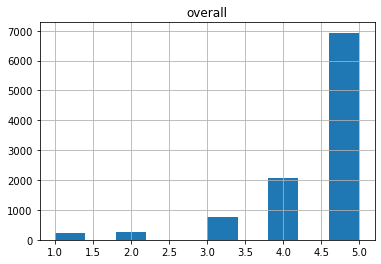

In [20]:
# Se muestra la distribución 
data_review_nodup.hist()

In [21]:
data = data_review_nodup.copy()

In [22]:
data.columns

Index(['reviewText', 'overall'], dtype='object')

In [23]:
stars_count = data['overall'].value_counts()
stars_count

5.0    6932
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

In [24]:
x = stars_count.index
height = stars_count.values

5.0    6932
4.0    2084
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

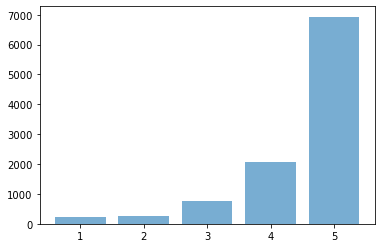

In [25]:
# Con el eje x mejorado, se muestra la distribución de estrellas
fig, ax = plt.subplots()
bar_obj = ax.bar(x = x, height = height, alpha=.6); stars_count

# N° de reviews positivas y negativas

In [26]:
# Se consideran a las reviews por encima de 3 estrellas como positivas. Las que tienen por debajo de 3 estrellas como negativas
# Se dejan de lado las reviews con 3 estrellas por considerarse neutrales.
data_scores = data[data['overall'] != 3.0].copy()
data_scores.shape 

print(f'Remaining data is {((data_scores.shape[0])/(data.shape[0]))*100}')

Remaining data is 92.47196489517309


In [27]:
score = data_scores['overall'].apply(lambda x: 1 if x > 3 else 0)
data_scores['Score'] = score
data_scores.head(3)

reviewText  overall  Score
0  Not much to write about here, but it does exac...      5.0      1
1  The product does exactly as it should and is q...      5.0      1
2  The primary job of this device is to block the...      5.0      1

In [28]:
scores_count = data_scores['Score'].value_counts()
scores_count

1    9016
0     467
Name: Score, dtype: int64

In [29]:
x = scores_count.index
height = scores_count.values

[Text(0, 0, 'Reviews Negativas'), Text(1, 0, 'Reviews Positivas')]

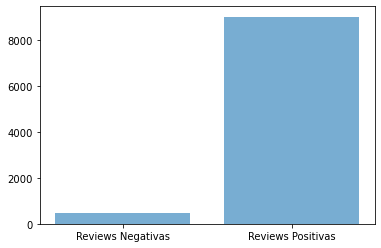

In [30]:
fig, ax = plt.subplots()
bar_obj = ax.bar(x = x, height = height, alpha=.6); scores_count
ax.set_xticks([0, 1])
ax.set_xticklabels(['Reviews Negativas', 'Reviews Positivas'])

In [31]:
# Hay claramente un desbalance de categorías.

# N-grams más frecuentes

In [32]:
data = data_review_nodup.drop('reviewText', axis=1)

In [33]:
data.columns

Index(['overall'], dtype='object')

In [34]:
data['reviews'] = pd.DataFrame(clean_texts)

In [35]:
data = data[['reviews', 'overall']]

In [36]:
data.columns

Index(['reviews', 'overall'], dtype='object')

In [37]:
# N-grams más frecuentes

In [38]:
texts_string = ' '.join(clean_texts)

In [39]:
texts_string

'not much to write about here  but it does exactly what it is supposed to  filters out the pop sounds  now my recordings are much more crisp  it is one of the lowest prices pop filters on amazon so might as well buy it  they honestly work the same despite their pricing  the product does exactly as it should and is quite affordable i did not realized it was double screened until it arrived  so it was even better than i had expected as an added bonus  one of the screens carries a small hint of the smell of an old grape candy i used to buy  so for reminiscent s sake  i cannot stop putting the pop filter next to my nose and smelling it after recording   dif you needed a pop filter  this will work just as well as the expensive ones  and it may even come with a pleasing aroma like mine did buy this product     the primary job of this device is to block the breath that would otherwise produce a popping sound  while allowing your voice to pass through with no noticeable reduction of volume or 

In [40]:
words_nltk = texts_string.lower().split()

In [41]:
bigrams_ = list(ngrams(words_nltk, 2))
trigrams_ = list(ngrams(words_nltk, 3))

In [42]:
bigrams_[:10]

[('not', 'much'),
 ('much', 'to'),
 ('to', 'write'),
 ('write', 'about'),
 ('about', 'here'),
 ('here', 'but'),
 ('but', 'it'),
 ('it', 'does'),
 ('does', 'exactly'),
 ('exactly', 'what')]

In [43]:
 trigrams_[:10]

[('not', 'much', 'to'),
 ('much', 'to', 'write'),
 ('to', 'write', 'about'),
 ('write', 'about', 'here'),
 ('about', 'here', 'but'),
 ('here', 'but', 'it'),
 ('but', 'it', 'does'),
 ('it', 'does', 'exactly'),
 ('does', 'exactly', 'what'),
 ('exactly', 'what', 'it')]

In [44]:
bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)

In [45]:
# 10 bigrams más frecuentes
bg_freq.most_common(10)

[(('it', 'is'), 5620),
 (('i', 'have'), 4675),
 (('of', 'the'), 3158),
 (('is', 'a'), 2841),
 (('i', 'am'), 2542),
 (('on', 'the'), 2458),
 (('if', 'you'), 2441),
 (('do', 'not'), 2176),
 (('this', 'is'), 2097),
 (('for', 'the'), 1966)]

In [46]:
# 10 tregrams más frecuentes
tg_freq.most_common(10)

[(('i', 'do', 'not'), 929),
 (('it', 'is', 'a'), 827),
 (('this', 'is', 'a'), 772),
 (('if', 'you', 'are'), 761),
 (('for', 'the', 'price'), 580),
 (('a', 'lot', 'of'), 490),
 (('it', 'is', 'not'), 472),
 (('i', 'have', 'been'), 453),
 (('it', 'does', 'not'), 440),
 (('and', 'it', 'is'), 434)]

# Nubes de palabras

In [47]:
print(len(texts_string))

5000236


In [48]:
 def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [49]:
clean_texts_no_stopwords = []
for text in data_review_nodup.reviewText:
    clean_texts_no_stopwords.append(clean_text(text, remove_stopwords = True))
print("Texts are complete.")

Texts are complete.


In [50]:
clean_texts_no_stopwords_string = ' '.join(clean_texts_no_stopwords)

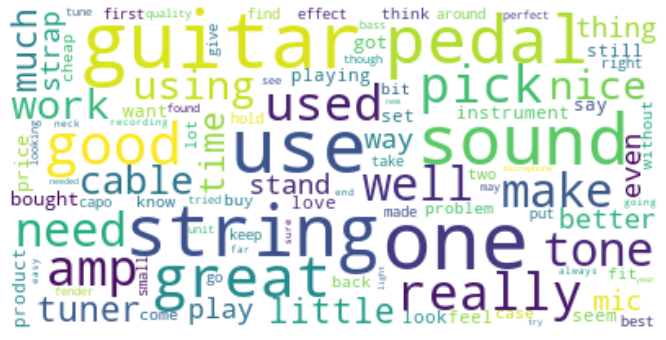

In [51]:
words_list = clean_texts_no_stopwords_string.lower().strip().split()
plot_word_cloud(words_list)

# Visualización en 2 dimensiones de algunos word embeddings calculados con Word2Vec (elegir 4-5 palabras y pintar las top 10 más similares)

In [52]:
clean_texts

['not much to write about here  but it does exactly what it is supposed to  filters out the pop sounds  now my recordings are much more crisp  it is one of the lowest prices pop filters on amazon so might as well buy it  they honestly work the same despite their pricing ',
 'the product does exactly as it should and is quite affordable i did not realized it was double screened until it arrived  so it was even better than i had expected as an added bonus  one of the screens carries a small hint of the smell of an old grape candy i used to buy  so for reminiscent s sake  i cannot stop putting the pop filter next to my nose and smelling it after recording   dif you needed a pop filter  this will work just as well as the expensive ones  and it may even come with a pleasing aroma like mine did buy this product    ',
 'the primary job of this device is to block the breath that would otherwise produce a popping sound  while allowing your voice to pass through with no noticeable reduction of v

In [53]:
with open('corpus_1.txt', 'w') as f:
    for line in clean_texts:
        f.write(line)
        f.write('\n')

In [54]:
# texts_string

corpus = LineSentence('corpus_1.txt', limit=200) # limit ??

In [55]:
#Hyperparameters

In [56]:
sg_params = {
    'sg': 1,
    #'size': 300,
    'vector_size':300,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4
}

cbow_params = {
    'sg': 0,
    #'size': 300,
    'vector_size':300,
    'min_count': 5,
    'window': 5,
    'hs': 0,
    'negative': 20,
    'workers': 4
}

In [57]:
# Inicializamos los objetos Word2Vec

In [58]:
# Skip Gram
w2v_sg = Word2Vec(**sg_params)

# CBOW
w2v_cbow = Word2Vec(**cbow_params)

In [59]:
# Construímos el vocabulario

In [60]:
 # Skip Gram
w2v_sg.build_vocab(corpus)

# CBOW
w2v_cbow.build_vocab(corpus)

In [61]:
print('Vocabulario compuesto por {} palabras'.format(len(w2v_sg.wv.key_to_index)))

Vocabulario compuesto por 412 palabras


In [62]:
 print('Vocabulario compuesto por {} palabras'.format(len(w2v_cbow.wv.key_to_index)))

Vocabulario compuesto por 412 palabras


In [63]:
# Entrenamos los pesos de los embeddings

In [64]:
# Skip Gram
w2v_sg.train(corpus_iterable=corpus, total_examples=w2v_sg.corpus_count, epochs=40)

(248377, 510320)

In [65]:
# CBOW
w2v_cbow.train(corpus_iterable=corpus, total_examples=w2v_cbow.corpus_count, epochs=40)

(248377, 510320)

In [66]:
# Guardamos los modelos

In [67]:
w2v_sg.save('w2v_sg_d300_mc5_w5.pkl')
w2v_cbow.save('w2v_cbow_d300_mc5_w5.pkl')

In [68]:
# #####

In [69]:
 w2v_sg = Word2Vec.load('w2v_sg_d300_mc5_w5.pkl')

In [70]:
 w2v_sg.wv.most_similar('guitar')

[('electric', 0.7598263621330261),
 ('his', 0.6929406523704529),
 ('great', 0.6609285473823547),
 ('fender', 0.65677809715271),
 ('monster', 0.642249345779419),
 ('instrument', 0.637367308139801),
 ('box', 0.6268360018730164),
 ('15', 0.6196487545967102),
 ('large', 0.6109655499458313),
 ('bass', 0.6093041300773621)]

In [71]:
 ##Creamos clusters de palabras con las más similares a unas dadas

In [72]:
keys = ['guitar', 'sound', 'cable', 'pedal']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_sg.wv.most_similar(word, topn=10):
        words.append(similar_word)
        embeddings.append(w2v_sg.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [73]:
 print(word_clusters)

[['electric', 'his', 'great', 'fender', 'monster', 'instrument', 'box', '15', 'large', 'bass'], ['reliable', 'tone', 'sturdy', 'identical', 'break', 'build', 'cool', 'products', 'without', 'quality'], ['fender', 'affordable', 'expect', 'length', 'unbalanced', 'short', 'everything', 'actually', 'mind', 'extra'], ['another', 'board', 'found', 'our', 'large', 'splitter', 'thought', 'while', 'his', 'hook']]


In [74]:
len(embedding_clusters[0][0])

300

In [75]:
# Reducimos dimensionalidad a 2D para poder representar

In [76]:
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

In [77]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

In [78]:
embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

In [79]:
# Visualización

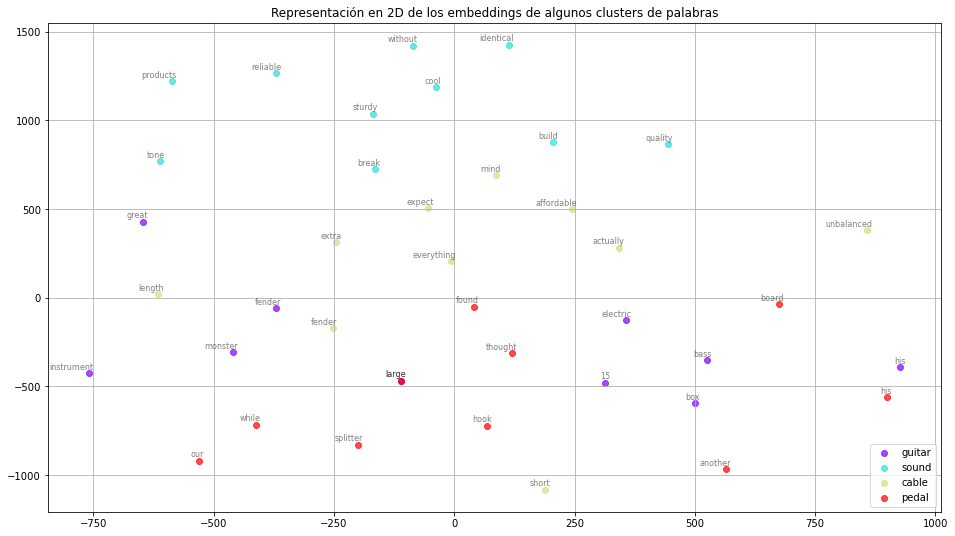

In [80]:
def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

# Conclusiones de la exploración

- Hay desbalance en las clases.
- Hay dígitos de los que tendré que hacerme cargo en la limpieza de los datos.
- Hay algunas filas con reviews en blanco.
- Pedal, guitar y String resaltan como los productos más comúnes en las reviews.
- Conservaré Stopwords por considerarse importantes para el tipo de análisis que se espera hacer.

In [81]:
# https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4